In [435]:
import ee 
import geemap
import matplotlib.pyplot as plt
import pandas as pd

## Initialisation 

In [361]:
ee.Initialize()
Map = geemap.Map()

In [453]:
import pandas as pd

dakar_roi = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1').filter(ee.Filter.eq("ADM1_NAME", "Dakar"))

# Fonction pour appliquer les facteurs d'échelle
def apply_scale_factors(image):
    
    optical_bands = image.select(['SR_B4', 'SR_B3', 'SR_B2']).multiply(0.0000275).add(-0.2)
    thermal_band_10 = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(optical_bands, None, True).addBands(
        thermal_band_10, None, True
    )
    
# Fonction pour calculer la température de surface
def calculate_surface_temperature(image):
    temperature = image.select('ST_B10')
    return temperature.rename('Temperature_en_°C')

# Sélectionner l'image Landsat 8, appliquer les facteurs d'échelle et calculer la LST
landsat8_image_dkr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2021-05-01', '2021-06-01'
).filterBounds(dakar_roi).map(apply_scale_factors).map(calculate_surface_temperature)

image_list = landsat8_image_dkr.toList(landsat8_image_dkr.size())

# I
lst_values = []
dates = []
hours  = []

# Parcourir la liste d'images et extraire les valeurs de LST
for i in range(image_list.size().getInfo()):
    
    image = ee.Image(image_list.get(i))
    date = ee.Date(image.get('system:time_start')).format("YYYY-MM-dd").getInfo()
    hour = ee.Date(image.get('system:time_start')).format("hh:mm:ss").getInfo()
    dates.append(date)
    hours.append(hour)
    
    lst_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=dakar_roi, scale=30).get('Temperature_en_°C').getInfo()
    lst_values.append(round(lst_value,2))

df = pd.DataFrame({'Jours': dates,"Heures":hours,'Temperature_en_°C': lst_values})

# Trier le DataFrame par date
df = df.sort_values(by=['Jours'])

df.head()

,Jours,Heures,Temperature_en_°C
1,2021-05-07,11:33:08,34.60
0,2021-05-16,11:27:04,40.70
2,2021-05-23,11:33:19,37.37


## VISUALISATION

Text(0.5, 1.0, 'Tempéraure en fonction du temps')

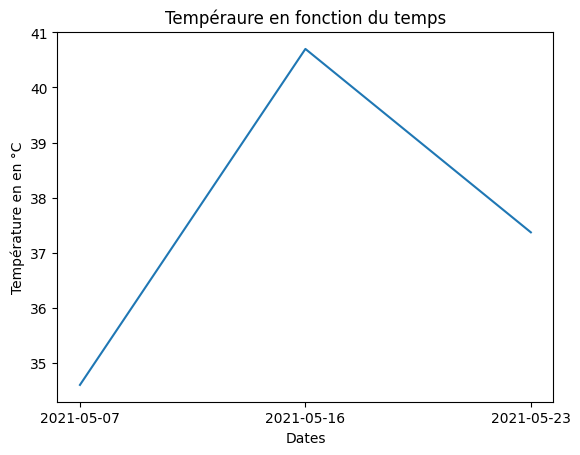

In [427]:
plt.plot(df["Date"], df['Temperature_en_°C'])
plt.xlabel("Dates")
plt.ylabel("Température en en °C")
plt.title('Tempéraure en fonction du temps')

## Visualisation avec les images 

In [445]:
from IPython.display import Image 

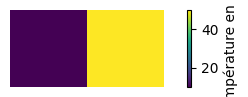

In [452]:
image = landsat8_image_dkr.first()

# Obtenir une URL pour afficher l'image de la température de surface
url = image.select('Temperature_en_°C').getThumbURL({'min': 18.47, 'max': 42.86, 'palette': ['blue', 'yellow', 'orange', 'red'],'dimensions': 512},
                                                    )

# Afficher l'image dans le notebook
display(Image(url=url))
# Afficher la légende de température
plt.figure(figsize=(6, 1))
plt.imshow([[10, 50]])
plt.colorbar(label='Température en °C')
plt.axis('off')
plt.show()

## 